In [3]:

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


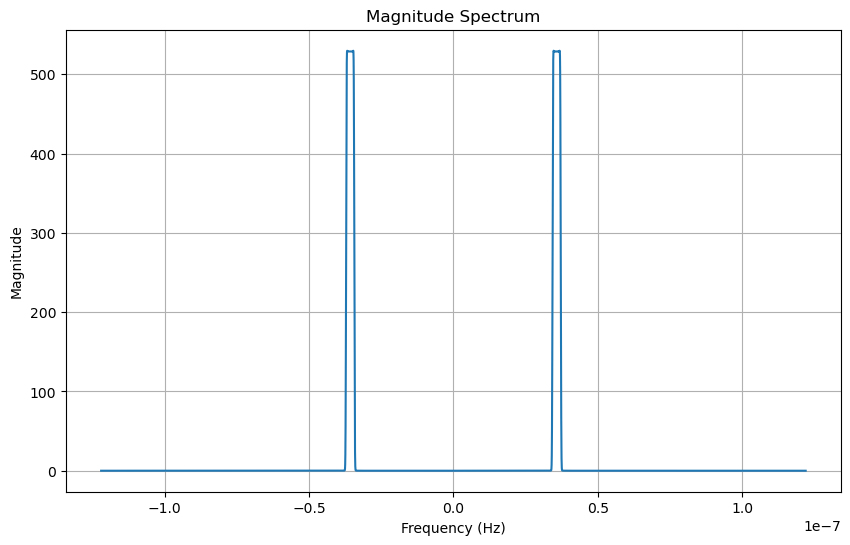

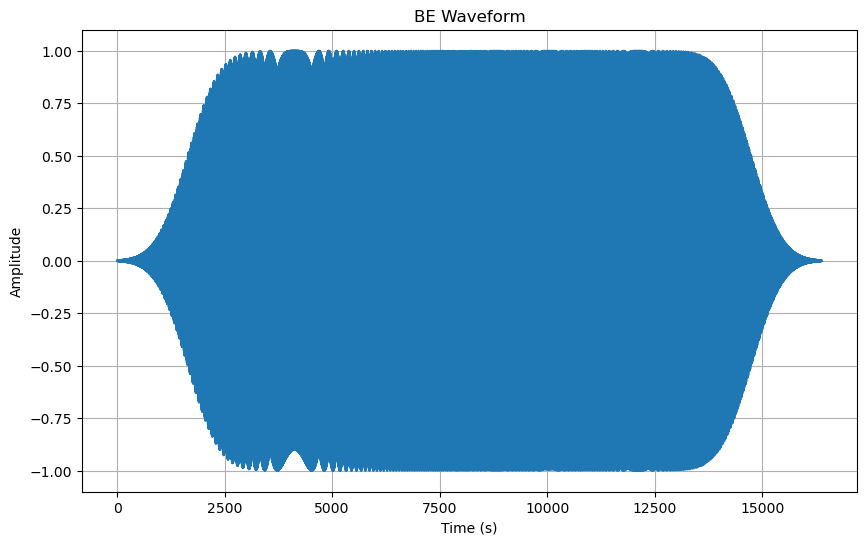

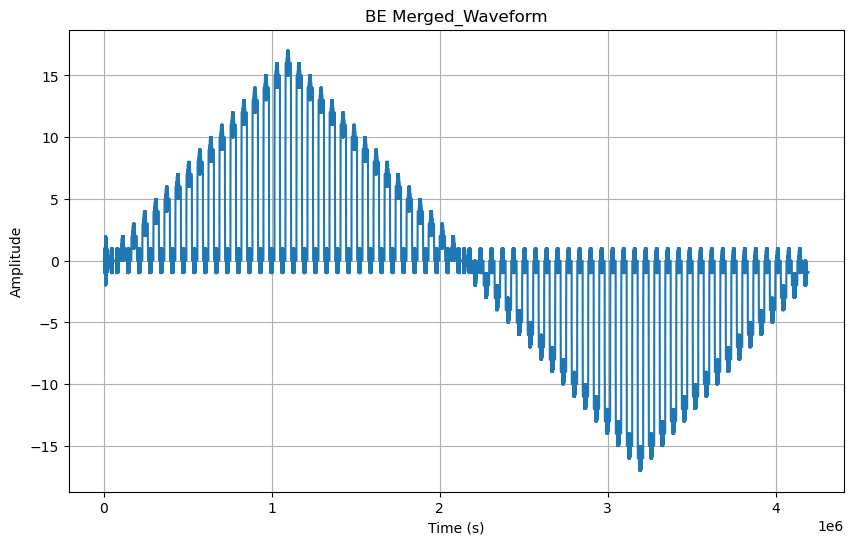

In [4]:
from BEWaveform import BEWaveform, Spectroscopy,BE_Viz, BE_Spectroscopy
import matplotlib.pyplot as plt

out = BE_Spectroscopy(14, 1, 600e3,60e3, wave= "chirp", BE_smoothing=125)
#in_a = Spectroscopy(int(14))
#in_b = BE_Spectroscopy.build_spectroscopy_waveform(out)

viz = BE_Viz(out)

 

viz.plot_fft()

viz.plot_waveform()
viz.plot_merged_waveform()